## Linear Regression

### Vectorization for Speed

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

- define a timer

In [3]:
class Timer:  #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

- 1. add them, one coordinate at a time, using a for-loop

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.20502 sec'

- 2. the reloaded + operator to compute the elementwise sum -> fast!

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

### The Normal Distribution and Squared Loss

In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

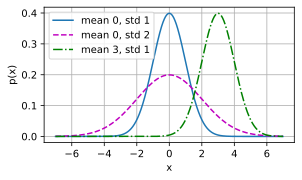

In [7]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

### Linear Regression Implementation from Scratch

In [8]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

- construct an artificial dataset according to a linear model with additive noise  

-> we generate a dataset containing 1000 examples, each consisting of 2 features sampled from a standard normal distribution

In [9]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

- each row in features consists of a 2-dimensional data example
- each row in labels consists of a 1-dimensional label value (a scalar)

In [10]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.7840, -1.3051]) 
label: tensor([10.2083])


- scatter plot using the second feature features[:, 1] and labels  

-> linear correlation between the two.

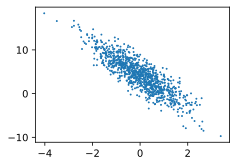

In [12]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

- read the data

In [13]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [14]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.5424, -0.2822],
        [-1.2570,  0.1944],
        [-0.0559,  1.2745],
        [-1.5009,  0.4849],
        [ 0.3836,  1.1902],
        [-0.7026,  0.1668],
        [-1.8561, -0.3443],
        [ 0.9422, -2.7780],
        [-0.4836,  0.8759],
        [ 0.1438, -1.4416]]) 
 tensor([[ 2.0830],
        [ 1.0128],
        [-0.2520],
        [-0.4559],
        [ 0.9218],
        [ 2.2245],
        [ 1.6560],
        [15.5200],
        [ 0.2531],
        [ 9.3897]])


- Initializing Model Parameters

In [15]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

- Defining the Model

In [16]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

- Defining the Loss Function : squared loss

In [17]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

- Defining the Optimization Algorithm : Minibatch stochastic gradient descent

In [18]:
def sgd(params, lr, batch_size):  #@save
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

- Training

In [19]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031178
epoch 2, loss 0.000102
epoch 3, loss 0.000047


In [20]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0004, -0.0003], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0003], grad_fn=<RsubBackward1>)


### Concise Implementation of Linear Regression

- Generating the Dataset

In [22]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

- Reading the Dataset

In [23]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [24]:
next(iter(data_iter))

[tensor([[ 3.0125, -0.5107],
         [ 1.1328,  1.0593],
         [-0.5198, -0.0207],
         [ 0.2320,  1.3729],
         [-0.7809, -1.5310],
         [-0.6105, -0.4081],
         [ 0.1310,  0.7226],
         [ 0.6404,  0.4701],
         [-1.5183, -0.8518],
         [-0.5191,  0.1617]]),
 tensor([[ 1.1968e+01],
         [ 2.8768e+00],
         [ 3.2143e+00],
         [-5.2824e-03],
         [ 7.8520e+00],
         [ 4.3685e+00],
         [ 2.0130e+00],
         [ 3.8815e+00],
         [ 4.0513e+00],
         [ 2.6072e+00]])]

- Defining the Model
- The **Sequential class** defines a container for several layers that will be chained together  

-> Given input data, a Sequential instance passes it through the first layer, in turn passing the output as the second layer’s input and so forth
- the fully-connected layer is defined in the **Linear class**

In [25]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

- Initializing Model Parameters

In [27]:
net[0].weight.data.normal_(0, 0.01)  # mean, deviation
net[0].bias.data.fill_(0)

tensor([0.])

- Defining the Loss Function

In [29]:
loss = nn.MSELoss()

- Defining the Optimization Algorithm

In [30]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

- Training  
Generate predictions by calling net(X) and calculate the loss l (the forward propagation).  
Calculate gradients by running the backpropagation.  
Update the model parameters by invoking our optimizer.  

In [31]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000207
epoch 2, loss 0.000100
epoch 3, loss 0.000100


In [32]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([-0.0003,  0.0002])
error in estimating b: tensor([-0.0006])
